# Validate YOLOv3 box detector

Calculate mean intersection over union for all test images

In [1]:
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.insert(0, "../scripts")
from prediction_utils import *
from shapely.geometry import Polygon

## Setup

In [2]:
src_path = os.path.join('..', 'YOLOv3', 'TrainYourOwnYOLO', "2_Training", "src")
utils_path = os.path.join('..', 'YOLOv3', 'TrainYourOwnYOLO', "Utils")

sys.path.append(src_path)
sys.path.append(utils_path)

# more imports here
from keras_yolo3.yolo import YOLO
from utils import detect_object

# Set up folder names for default values
data_folder = os.path.join('..','YOLOv3','TrainYourOwnYOLO', "Data")
image_folder = os.path.join(data_folder, "Source_Images")
image_test_folder = os.path.join(image_folder, "Test_Images")
model_folder = os.path.join(data_folder, "Model_Weights")
model_weights = os.path.join(model_folder, "trained_weights_final_ck2000.h5")
model_classes = os.path.join(model_folder, "data_classes.txt")
anchors_path = os.path.join(src_path, "keras_yolo3", "model_data", "yolo_anchors.txt")

# define YOLO detector
yolo = YOLO(
    **{
        "model_path": model_weights,
        "anchors_path": anchors_path,
        "classes_path": model_classes,
        "score": 0.25,
        "gpu_num": 1,
        "model_image_size": (416, 416),
    }
)

# set test image directory
test_dir = os.path.join('..', 'data', 'synthesized300')
png_dir = os.path.join(test_dir, 'PNG')
img_files = os.listdir(png_dir)

# load target data
all_targets = np.load(os.path.join(test_dir, 'targets.npy'), allow_pickle=True)[()]

Using TensorFlow backend.
W0611 09:48:03.819013 140357116561152 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0611 09:48:03.819796 140357116561152 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0611 09:48:03.820429 140357116561152 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0611 09:48:03.837202 140357116561152 module_wrapper.py:139] From /home/perry/anaconda3/envs/cerealkiller2_YOLO_py37/lib/python3.7/site-packages/keras/ba

../YOLOv3/TrainYourOwnYOLO/Data/Model_Weights/trained_weights_final_ck2000.h5 model, anchors, and classes loaded in 7.85sec.


## Calculate IoU

In [3]:
def get_IoU(bb1, bb2):
    """ Compute intersection over union """
    a = Polygon([(bb1[0],bb1[1]), (bb1[0], bb1[3]), (bb1[2], bb1[3]), (bb1[2], bb1[1])])
    b = Polygon([(bb2[0],bb2[1]), (bb2[0], bb2[3]), (bb2[2], bb2[3]), (bb2[2], bb2[1])])
    return a.intersection(b).area / a.union(b).area


## Calculate mean IoU for all test images

In [4]:
# set minimum overlap threshold
overlap_threshold = 0.2

sumIoU = 0.0  # this becomes the numerator in the average
counter = 0   # this becomes the denomenator in the average
    
# Loop through test images
for file in img_files:
    print(f"\nLoading image: {file}")
    img = Image.open(os.path.join(png_dir, file)).convert("RGB")

    # set target for this image
    targets = all_targets[file]

    # Run YOLO detector
    new_img = copy.deepcopy(img)
    YOLO_predictions, new_image = yolo.detect_image(new_img);


    matched_gt = []
    matched_p = []
    # loop through groundtruth boxes
    for targetID, target in enumerate(targets):
        gt_bb = target['bbox']

        # loop through predicted boxes
        maxIoU = 0
        maxID = -1
        for ix, p_bb in enumerate(YOLO_predictions):
            if ix in matched_p:
                continue

            # calculate IoU
            IoU = get_IoU(gt_bb, p_bb)

            # find best score
            if IoU > maxIoU:
                maxIoU = IoU
                maxID = ix

        print(f"Target {targetID}; Max IoU: {maxIoU}")

        # Delete ground truth and predicted boxes from their respective arrays if overlap exceeds threshold
        if maxIoU > overlap_threshold:
            sumIoU += maxIoU
            counter += 1

            matched_gt.append(targetID)
            matched_p.append(maxID)

    # Deal with possibility that a ground truth box didn't have a corresponding predicted box or vice versa
    counter += len(YOLO_predictions) - len(matched_p)
    counter += len(targets) - len(matched_gt)


# compute average        
avgIoU = sumIoU / counter


print(f"Average IoU: {avgIoU}")


Loading image: 00000.png
(416, 416, 3)
Found 6 boxes for img
cereal_box 0.99 (31, 60) (71, 115)
cereal_box 1.00 (164, 42) (207, 118)
cereal_box 1.00 (164, 126) (196, 204)
cereal_box 1.00 (46, 145) (78, 188)
cereal_box 1.00 (2, 145) (34, 201)
cereal_box 1.00 (80, 55) (144, 153)
Time spent: 1.385sec
Target 0; Max IoU: 0.9550753925073838
Target 1; Max IoU: 0.9868421052631579
Target 2; Max IoU: 0.9405984814649397
Target 3; Max IoU: 0.9555555555555556
Target 4; Max IoU: 0.9696969696969697
Target 5; Max IoU: 0.9361702127659575

Loading image: 00001.png
(416, 416, 3)
Found 6 boxes for img
cereal_box 1.00 (125, 120) (169, 187)
cereal_box 1.00 (180, 108) (222, 171)
cereal_box 1.00 (29, 13) (61, 60)
cereal_box 1.00 (81, 10) (112, 57)
cereal_box 1.00 (147, 51) (179, 97)
cereal_box 1.00 (10, 82) (96, 213)
Time spent: 0.515sec
Target 0; Max IoU: 0.969694330749804
Target 1; Max IoU: 0.9710144927536232
Target 2; Max IoU: 1.0
Target 3; Max IoU: 0.9615952732644018
Target 4; Max IoU: 0.9696969696969697

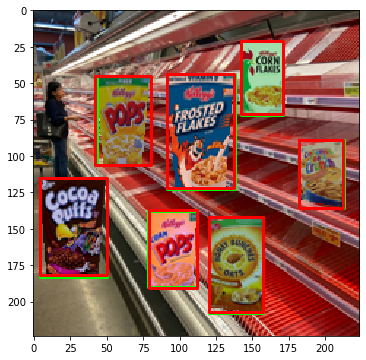

In [5]:
# plot
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(np.array(img));

for target in targets:
    box = target['bbox']
    ax.plot([box[0],box[2], box[2],box[0],box[0]], [box[1],box[1],box[3],box[3],box[1]], linewidth=3, color='lime')
for pred in YOLO_predictions:
    ax.plot([pred[0],pred[2], pred[2],pred[0],pred[0]], [pred[1],pred[1],pred[3],pred[3],pred[1]], linewidth=3, color='red')